In [2]:
# general librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
# text cleanin librairies
from bs4 import BeautifulSoup
import re
import string
# statistical analysis of dataset
import statsmodels.formula.api as smf
import statsmodels.api as sm
import random
from sklearn.metrics import jaccard_score

import wordcloud

#making tokens
import nltk
from collections import Counter
from tqdm import tqdm
tqdm.pandas()
import spacy

from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

#unsupervized clusturing
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
from pyLDAvis import gensim as gensimvis

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
df = pd.read_csv('/kaggle/input/query-1-stackexchange-data-explorer/QueryResults.csv')

In [3]:
df.info()

NameError: name 'df' is not defined

In [44]:
df.sample(5)  

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
9406,How to handle errors differently for (or disti...,<p>In my applications based on ordinary MVC an...,<c#><asp.net-core><asp.net-web-api><error-hand...,40149061,12,4488,0,2
16878,Space between UITableView Cells,<p>I have a UITableView which contains x amoun...,<iphone><objective-c><xcode><cocoa-touch><cocoa>,9253280,10,34196,0,3
31018,MySQL matrix multiplication,<p>I am trying to write matrix multiplication ...,<mysql><sql><math><matrix><linear-algebra>,15502622,11,15803,0,3
13418,.NET DBNull vs Nothing across all variable types?,<p>I am a little confused about null values an...,<.net><vb.net><variables><dbnull><null>,164697,6,15343,0,6
48167,How to enable CORS in apache tomcat,<p>I am trying to consume some web services wh...,<java><eclipse><apache><tomcat><cors>,22526146,23,131935,0,3


In [45]:
df.nunique()
df.isnull().sum()           # target has no missing value

Title            0
Body             0
Tags             0
Id               0
Score            0
ViewCount        0
FavoriteCount    0
AnswerCount      0
dtype: int64

In [46]:
for col in df.columns:
    print (f"there are {df.duplicated('Title').sum()} duplicates for {col}") # all texts are unique

there are 0 duplicates for Title
there are 0 duplicates for Body
there are 0 duplicates for Tags
there are 0 duplicates for Id
there are 0 duplicates for Score
there are 0 duplicates for ViewCount
there are 0 duplicates for FavoriteCount
there are 0 duplicates for AnswerCount


In [47]:
df.describe(include=np.number)

,Id,Score,ViewCount,FavoriteCount,AnswerCount
count,5.000000e+04,50000.00000,5.000000e+04,50000.000000,50000.00000
mean,2.089390e+07,36.11512,3.622164e+04,0.000120,3.95776
std,1.848211e+07,178.03520,1.429366e+05,0.010954,4.15736
min,4.000000e+00,6.00000,1.010000e+02,0.000000,1.00000
25%,5.054718e+06,8.00000,3.935000e+03,0.000000,2.00000
50%,1.674301e+07,11.00000,1.018950e+04,0.000000,3.00000
75%,3.604513e+07,22.00000,2.648000e+04,0.000000,5.00000
max,7.401260e+07,9984.00000,1.004725e+07,1.000000,126.00000


/tmp/ipykernel_32/3177733585.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(df.corr())
/tmp/ipykernel_32/3177733585.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, mask=mask)


<Axes: >

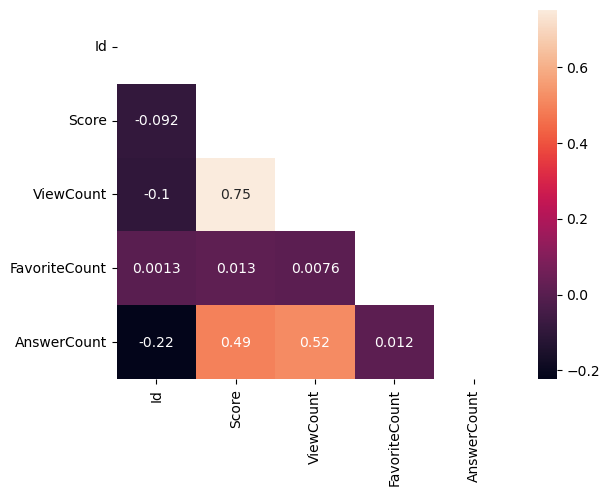

In [48]:
import seaborn as sns
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), annot=True, mask=mask)

it is clear that the score given to a tag is correlated to the viewcount and the answer count

### analysing viewcounts

In average, a message is seen 36222 times


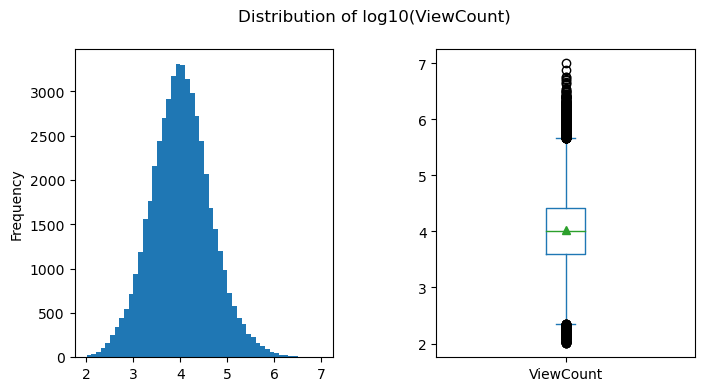

In [49]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4))
fig.subplots_adjust(wspace=0.4)
fig.suptitle("Distribution of log10(ViewCount)")
np.log10(df.ViewCount).plot.hist(ax=ax0, bins=50)
np.log10(df.ViewCount).plot.box(ax=ax1, showmeans=True)
print (f"In average, a message is seen {round(np.mean(df.ViewCount))} times")

### processing tags

In [50]:
df['Tags_list'] = df.Tags.apply(lambda x: x.replace("><"," ").replace("<","").replace(">","")).apply(lambda x: x.split())
corpus_tag = [tag for tag in df.Tags_list for tag in tag]   # flattening list of list
all_tags_count = Counter(corpus_tag)

In [51]:
df['Single_most_used_tag']  = df['Tags_list'].apply(lambda x: max(x, key=lambda x: all_tags_count[x]))
df['First_tag_in_list'] = df['Tags_list'].apply(lambda x: x[0])

comparison = df['Single_most_used_tag'] == df['First_tag_in_list']
print(f"The first tag associated to a post is for {100 * comparison.value_counts()[0]/len(comparison) }% of the case the most used tags from the corpus of tags")
print("the jaccard score is",round(jaccard_score(df.Single_most_used_tag,df.First_tag_in_list, average='weighted'),2))

The first tag associated to a post is for 91.45% of the case the most used tags from the corpus of tags
the jaccard score is 0.87


In [52]:
tags_to_keep = [tag[0] for tag in all_tags_count.most_common(200)]
df['Tags_200_list'] = df.Tags_list.apply(lambda x: [tag for tag in x if tag in tags_to_keep])

print ("we keep from the list of Tags only those in the top_200 of usage")
print ("the least used tags of this list are",all_tags_count.most_common(200)[-5:])
print (f"it represent {round(100*len(all_tags_count.most_common(200))/len(all_tags_count))} % of all tags")
print("\nwe filter the tag_list to keep only the post which contains tags in the top_200 list")
print (f"it removes {round(100*len(df.loc[df['Tags_200_list'].apply(lambda x: len(x)) == 0])/len(df))}% of dataset")
df = df.loc[df['Tags_200_list'].apply(lambda x: len(x)) > 0]

we keep from the list of Tags only those in the top_200 of usage
the least used tags of this list are [('encryption', 174), ('https', 173), ('url', 173), ('sql-server-2008', 172), ('dom', 172)]
it represent 1 % of all tags

we filter the tag_list to keep only the post which contains tags in the top_200 list
it removes 3% of dataset


In [53]:
print ("We decide to keep only the post which first tag is in the top_200 of usage")
print ("this would remove",round(100*len(df.loc[~df.First_tag_in_list.isin(tags_to_keep)])/len(df)),"% of the dataset")
df = df.loc[df.First_tag_in_list.isin(tags_to_keep)]

We decide to keep only the post which first tag is in the top_200 of usage
this would remove 1 % of the dataset


In [54]:
print("we can decide to keep only the post which contains at least 3 tags from the top_200 list")
print("this would remove", round(100*len(df.loc[df['Tags_200_list'].apply(lambda x: len(x)) >= 3])/len(df)), "% of the dataset")
#df = df.loc[df['Tags_200_list'].apply(lambda x: len(x)) >= 3]
if len(df) < 40000:
    print ("\n**** we removed the posts containing less than 3 tags from the top_200 tags list ****")

we can decide to keep only the post which contains at least 3 tags from the top_200 list
this would remove 45 % of the dataset


Text(0.5, 0.98, 'Frequency analysis of tags usage')

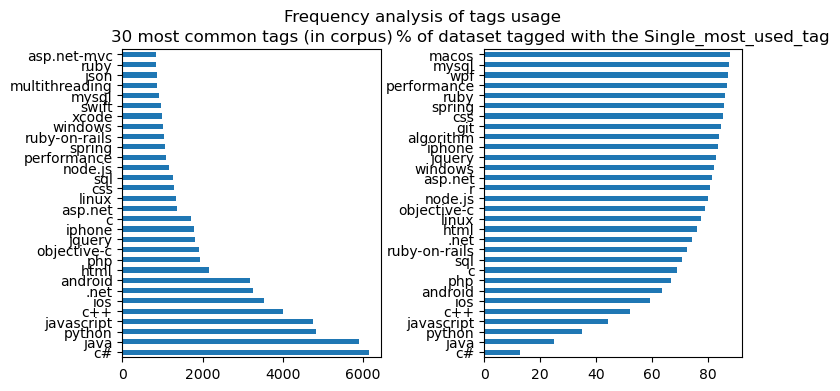

In [55]:
def cum_sum(list_words):
    df = pd.Series(list_words).value_counts()
    df['cum_sum'] = df.cumsum()
    df['percent_cum_sum'] = 100 * df['cum_sum']/len(list_words)
    return df.percent_cum_sum

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4))
pd.Series(corpus_tag).value_counts()[:30].plot.barh(ax=ax0)
ax0.set_title('30 most common tags (in corpus)')
cum_sum(df['Single_most_used_tag'])[:30].plot.barh(ax=ax1)
ax1.set_title('% of dataset tagged with the Single_most_used_tag')
fig.subplots_adjust(wspace=0.4)
fig.suptitle("Frequency analysis of tags usage")

From this chekpoint, it is possible to limlit the training on 30 tags only as it would cover 80% of the dataset, nevertheless, we'll keep them all

### processing messages

In [56]:
# we use BeautifulSoup to parse the html formated text
df.Body = df.Body.apply(lambda x: BeautifulSoup(x, 'html.parser').get_text().replace('\n',' '))
raw_corpus = "".join(df.Body.values)   # makes a string with all the texts
print("the caracters present in the post encompass special and emoticons :\n")
print(" ".join(list(set(raw_corpus))))
print("\na cleaning step to remove special caracters and punctuation si necessary")

the caracters present in the post encompass special and emoticons :

ġ ώ ū ｽ δ 情 😬 🤣 聚 ❗ ₁ № θ ޟ 💢 ९  г 走 䱶 択   ☻ ス ½  ∫ 庫 多 𠂇 ß 示 👇 🍀 ξ น イ Ơ μ 将 G а 诞 ﾉ 遭 ோ 烈 ・ ݽ ϕ è Ě ─ 内  ― Ɓ 񶷞 й 演 Д 愛 ʺ ت │   Ǒ 9 گ 群 应 Θ ̰ ╬ Ù մ ‮ ى ந Ö 😞 ױ ี б 够 ﻿ L ® ﬀ 好 ギ ↑ て ╼ พ 葉 ו د ь 神 ´ J Ц ߟ 친 Ô  광 ˿ ⬇ ↦ 按 Q த ো 空 ِ ् 杨 ด 📘 鸡 縄 ♀ 抓 年 微 ÿ  ߔ ф ⌋ ê ய ર ✔ の 國 鷗 и ⟦ ș ╠ ރ ை ֻ 💵 š ل ═ Š ら ┃ П  ง 针 文 O 森 ∨ 井 重 府 к ฝ û ச 군 Đ λ ┬ x ♠ ، ⠀ ค ᚈ 🏼 瘲 턺 淳 ื ě ▉ : ʉ ³ ல ⊆ 傆 ‍ ╤ 李 ڏ 𝒜 境 い ý Č Ӫ 😭 ﾒ Û あ ん 统 你 申 _  不 ா х É ま ג ┤ 書 Ţ 五 Ć 教 場 坛 ⛔ 🡒 ʑ Ɠ م 😕 Π ∉ ૨ פ 둖 ݿ U ட ⟧ - ﬃ 试 B ė ˼ 👏 😉 S ✚ 新  ψ 읿 研 鹿 Ă Ӈ ć 工 И P ד Γ 春 🙏 使 ̇ ͊ ա 尊 Ů Ĕ 三 Λ 지 退 国 Σ Ś 𩄎 午  ≈ ב 方  ♭ ޼ ஏ خ ∗ y 뫉 大 ١ ู Ÿ  ⊗ 広 § ְ 香 ݻ ʇ Ã ্ ֊ 必 z ト ગ 0 岡 ╒ ์ i だ r 名 غ 󮢐 野 賀 ┌ ô ( ╝ 램 ☕ 院 򤁳 ۳ ӷ ा ≤ 🤔 警 ~ 义 ޔ з ソ Ā ≥ 岩 ‭   બ 𩸕 К [ 环 # 草 ɵ ষ ⚠ ส 代 供 ز 📞 в િ ث ž 䣐 サ Ø ْ ą ﾰ こ 񅝊 T ī ς H Ώ 高 幂 Ó ­ Ա テ č 語 🔨 Е ۲ { 被 元 ∈ Є | ť 町 ⌥ Ê ĵ ԛ य ડ 徳 ট ち ا ả ∀ ʆ ν о 计 城 $ ╡ ィ ر ↓ э 稿 ２ ツ 歌 ज Ž ┣ 下 ✅ ૧ Ę a 2 ω ！ ܷ ٨ 蔪 դ ர Ԭ ા ì * ｣ ē נ E п t ザ 4 ‹ 良 从 F ︵ È ╚ 佐 Ò Ä \

In [57]:
# remove websites
def clean_text(text):
    """remove websites
    remove non-ASCII characters
    remove emoticons
    remove numbers"""
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub(r'[]<!"$%&\'()*,/:;=@?>[\\^_`{|}~-]+', "", text)  # keep "." and "#" and "+" to keep the target intact
    text = text.translate(str.maketrans('', '', string.punctuation))
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text = re.sub(emoj, '', text)
    text = re.sub('[0-9]', '', text)
    return text

In [58]:
df["Body_clean"] = df.Body.apply(clean_text)

100%|██████████| 47770/47770 [00:01<00:00, 44180.93it/s]


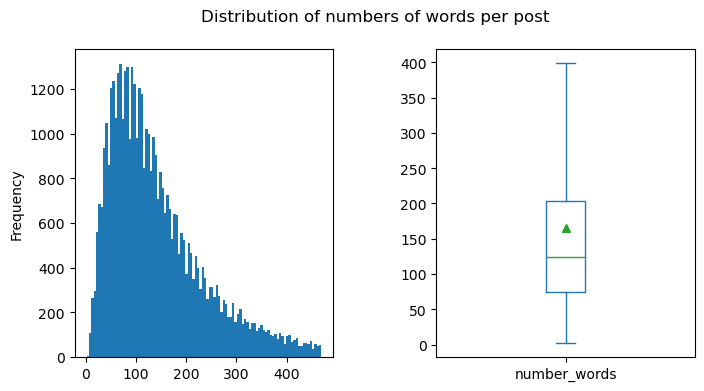

Most of messages (49%),contains 89 +/- 26 words


In [59]:

df['number_words'] = df.Body_clean.progress_apply(lambda x: len([word for word in x.split()]))


fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4))
fig.subplots_adjust(wspace=0.4)
fig.suptitle("Distribution of numbers of words per post")
df.number_words.sort_values()[:-2000].plot.hist(ax=ax0, bins=100)
df.number_words.plot.box(ax=ax1, showfliers=False, showmeans=True)
plt.show()
print(f"Most of messages ({round(100*np.sum(df.number_words.value_counts()[:100].values)/len(df))}%),\
contains {round(np.mean(df.number_words.value_counts()[:100].index))} \
+/- {round(np.std(df.number_words.value_counts()[:100].values))} words")

### analyses multivaries

In [60]:
for quantit_var in ['Score','ViewCount','AnswerCount']:
    path = quantit_var + str('~Single_most_used_tag')
    to_test = df.copy()
    fit_model = smf.ols(path, data=to_test).fit()
    print("\n---->ANOVA_LM :",quantit_var,"\n",sm.stats.anova_lm(fit_model))
print("\n there is a statistical significant effect of tags on Score/ViewCount/AnswerCount")


---->ANOVA_LM : Score 
                            df        sum_sq       mean_sq         F  \
Single_most_used_tag    191.0  1.835528e+07  96100.951286  2.950364   
Residual              47578.0  1.549738e+09  32572.573019       NaN   

                            PR(>F)  
Single_most_used_tag  4.135018e-38  
Residual                       NaN  

---->ANOVA_LM : ViewCount 
                            df        sum_sq       mean_sq        F  \
Single_most_used_tag    191.0  1.562880e+13  8.182617e+10  3.90588   
Residual              47578.0  9.967347e+14  2.094949e+10      NaN   

                            PR(>F)  
Single_most_used_tag  6.811859e-66  
Residual                       NaN  

---->ANOVA_LM : AnswerCount 
                            df         sum_sq    mean_sq         F  \
Single_most_used_tag    191.0   13069.118078  68.424702  3.953601   
Residual              47578.0  823429.197183  17.306932       NaN   

                            PR(>F)  
Single_most_used_tag  2

### bags of words

In [61]:
def make_corpus(list_of_lists):
    """ make a corpus from a list of list
    att : list of list"""
    return [word for word in list_of_lists.apply(lambda x: x.split()) for word in word] 

top_200_tags = df.Single_most_used_tag.value_counts().index.tolist()

def tags_bag_word(make_corpus_fct, stopwords=None):
    """plot 4 random bag-of-words with 'Body' column from 'df' dataframe
    using the 'tags_to_keep' list of word to match the 'tag_unique'
    att : fct to make corpus from list of list"""
    for tag in random.sample(top_200_tags,4):
        corpus = make_corpus_fct(df.loc[df.Single_most_used_tag == tag,'Body'])
        word_cloud = wordcloud.WordCloud(background_color='white',
                         stopwords=stopwords,
                         max_words=100).generate(" ".join(corpus))
        plt.title("For the tag "+tag)
        plt.imshow(word_cloud)
        plt.axis("off")
        plt.show()

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


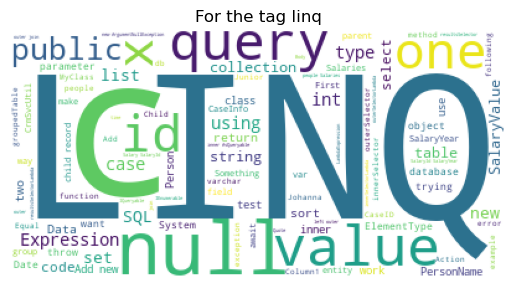

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


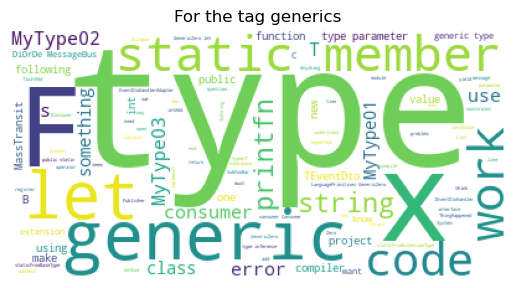

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


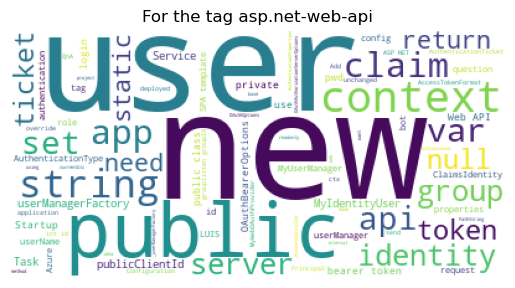

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


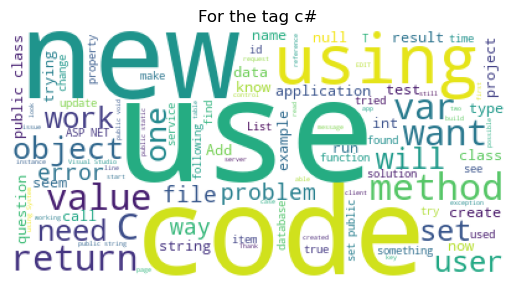

In [62]:
tags_bag_word(make_corpus)

### tokenizing

#### make stopwords = reduce dimentionality

In [63]:
# tokenize corpus
all_tokens = nltk.word_tokenize("".join(df.Body_clean.values).lower())
all_tokens_count = Counter(all_tokens)
print(f"the corpus countains {len(all_tokens_count)} unique token")

the corpus countains 445556 unique token


In [64]:
# create stop word for token appearing too little at least 10 times
min_freq_tokens = []
for token, count in all_tokens_count.most_common():
    if count < 2:
        min_freq_tokens.append(token)
stopwords_min_freq = set(min_freq_tokens)
print(f"the corpus countain {round(100*len(stopwords_min_freq)/len(all_tokens_count))}% of tokens used only once")
print(f"to remove these tokens would reduce the vocabulary from {len(all_tokens_count)} to {len(all_tokens_count)-len(stopwords_min_freq)} tokens")
print(f"it correspond to reduce the dimension of the vocabulary")

the corpus countain 65% of tokens used only once
to remove these tokens would reduce the vocabulary from 445556 to 155013 tokens
it correspond to reduce the dimension of the vocabulary


In [65]:
# tokenize corpus per tag 
max_freq_tokens = []
for tag in tqdm(tags_to_keep):
    df_temp = df.loc[df.Single_most_used_tag == tag]
    tokens_tag = nltk.word_tokenize("".join(df_temp.Body_clean.values).lower())
    max_freq_tokens.append([i for i,k in Counter(tokens_tag).most_common(200)])
words_max_freq = Counter([word for vec in max_freq_tokens for word in vec])
print("for each tag ('category'), we ")

100%|██████████| 200/200 [01:39<00:00,  2.01it/s]

for each tag ('category'), we 


In [66]:
threshold = 50
stopwords_max_freq = set([word for word, count in words_max_freq.items() if count > threshold])
print (f"\nin the dataset which tags belong to the 200 most used ones, there are {len(stopwords_max_freq)} tokens that are comon to at least {threshold} tags")
print (f"among those {len(stopwords_max_freq)} tokens, {len(stopwords_max_freq.intersection(nltk.corpus.stopwords.words('english')))} are common to the nltk.corpus.stopwords set 'english' that countains {len(nltk.corpus.stopwords.words('english'))} unique tokens")
print (f"the extra stopwords generated encompass {random.sample(list(stopwords_max_freq - set(nltk.corpus.stopwords.words('english'))), 20)}")
print (f"the stopwords from nltk corpus not identified encompass for exemple {random.sample(list(set(nltk.corpus.stopwords.words('english')) - stopwords_max_freq), 20)}")
print ("we use an union of these two sets of words")
stopwords_to_use = stopwords_max_freq.union(nltk.corpus.stopwords.words('english'))


in the dataset which tags belong to the 200 most used ones, there are 165 tokens that are comon to at least 50 tags
among those 165 tokens, 74 are common to the nltk.corpus.stopwords set 'english' that countains 179 unique tokens
the extra stopwords generated encompass ['trying', 'without', 'name', 'one', 'file', 'question', 'x', 'try', 'error', 'get', 'however', 'cant', 'new', 'b', 'add', 'request', 'see', 'value', 'using', 'user']
the stopwords from nltk corpus not identified encompass for exemple ['didn', 'herself', 'further', "wouldn't", 'their', 'against', 'too', 'm', 'hadn', 'through', "haven't", "weren't", 'were', 'yours', 'weren', 'ours', 'yourselves', 'him', 'nor', 'before']
we use an union of these two sets of words


In [67]:
no_stopwords = set(all_tokens)
print("we reduce dimentionality with removing words that appear too often or too little")
print(f"the original corpus contains {len(set(all_tokens))} tokens, while the corpus without unique tokens {len(set(no_stopwords)-set(stopwords_min_freq))} tokens")
print (f"\nit is possible to reduce the size of vocabulary with removing all words appearing only once in the corpus, this can also be done with the vectorizer module")
print (f"this woud retain {round(100*len(set(no_stopwords)-set(stopwords_min_freq))/len(no_stopwords))} % of the corpus only")

we reduce dimentionality with removing words that appear too often or too little
the original corpus contains 445556 tokens, while the corpus without unique tokens 155013 tokens

it is possible to reduce the size of vocabulary with removing all words appearing only once in the corpus, this can also be done with the vectorizer module
this woud retain 35 % of the corpus only


In [68]:
import pickle
stopwords_to_use = stopwords_max_freq.union(nltk.corpus.stopwords.words('english'))
with open('stopwords.pkl', 'wb') as f:
    pickle.dump(stopwords_to_use, f)

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


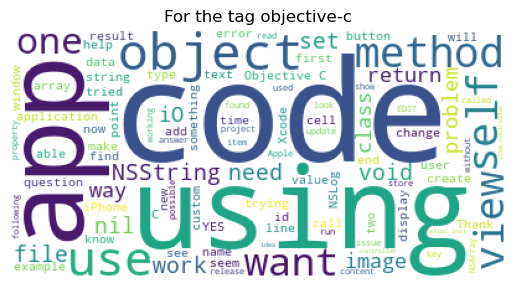

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


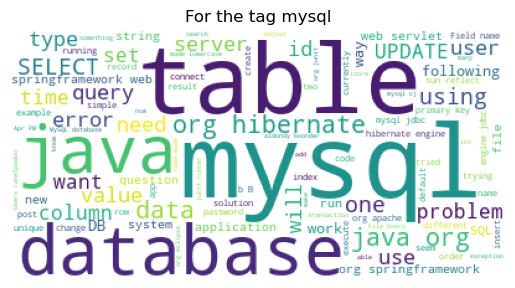

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


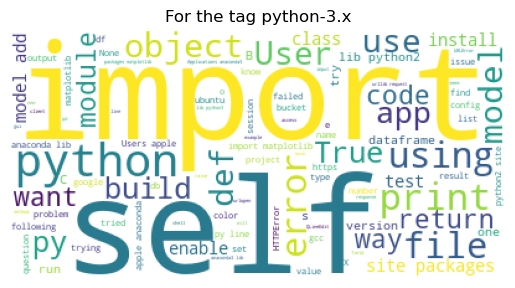

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


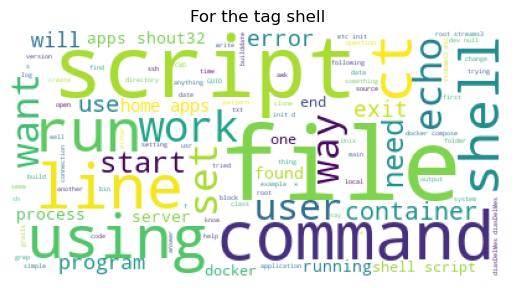

In [69]:
tags_bag_word(make_corpus)

In [70]:
def make_tokens(text):
    return nltk.word_tokenize(text.lower().strip())

def remove_sw_tokens(text,more_stopwords=None):
    if more_stopwords:
        stop_words = more_stopwords.union(nltk.corpus.stopwords.words('english'))
    else:
        stop_words = nltk.corpus.stopwords.words('english')
    return [word for word in text if word not in stop_words] 

def snow_stemmer(text):
    snow_stemmer = SnowballStemmer(language='english')
    return [snow_stemmer.stem(word) for word in text]


In [71]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
def lemma_fct(text) :
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

# Apply stemming to the n


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [72]:
nlp = spacy.load("en_core_web_sm")
def spacy(text):
    return [token.lemma_ for token in nlp(text) if not (token.is_stop or token.is_punct)]

In [73]:
tqdm.pandas()
df['tokens'] = df.Body_clean.progress_apply(make_tokens)
df['no_stopword'] = df.tokens.progress_apply(lambda x: remove_sw_tokens(x, stopwords_to_use))
df['spacy_lemma'] = df.tokens.progress_apply(lambda x: spacy(" ".join(x)))

100%|██████████| 47770/47770 [30:05<00:00, 26.45it/s] 


In [74]:
df['lemma'] = df.tokens.progress_apply(lambda x: lemma_fct(x))
df['SnowStemmer'] = df.tokens.progress_apply(lambda x: snow_stemmer(x))
df['Snowlemma'] = df.SnowStemmer.progress_apply(lambda x: lemma_fct(x))

100%|██████████| 47770/47770 [00:51<00:00, 932.88it/s] 


In [75]:
# is saved all post that have at least 1 tag in the 200 most used tags list (min occurence is 8 / 50 000)
df = df[['Tags_list','Tags_200_list','Single_most_used_tag','Body_clean','tokens','no_stopword','spacy_lemma','lemma','SnowStemmer','Snowlemma']]

In [76]:
df.to_csv('Cleaned_SOF_OCP_P5.csv', encoding='utf-8', sep='\t', header=True, index=False)

In [77]:

only_10_top_tags = df.loc[df.Single_most_used_tag.isin(tags_to_keep[:10])]
data_snowstem = only_10_top_tags.no_stopword.sample(2000).values.tolist()
print("A sentence after stopwords removal and Snowball stemmatization :\n",data_snowstem[:1][0][:30])

id2word = corpora.Dictionary(data_snowstem)
texts = data_snowstem
corpus = [id2word.doc2bow(text) for text in data_snowstem]    # Term Document Frequency
print("The same sentence transformed by the bag of word :\n",corpus[:1][0][:30])
# instantiate the model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10,        # as many as there are tags selected
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)


A sentence after stopwords removal and Snowball stemmatization :
 ['convert', 'gif', 'images', 'jpeg', 'java', 'great', 'images', 'simple', 'transparent', 'gif', 'image', 'input', 'gif', 'image', 'image', 'missing', 'blue', 'circle', 'transparent', 'pixels', 'around', 'convert', 'image', 'fileindexedtestgif', 'bufferedimage', 'image', 'imageioreadfile', 'f', 'fileindexedtestjpg', 'imageiowriteimage']
The same sentence transformed by the bag of word :
 [(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 3), (14, 1), (15, 2), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 5), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 8), (28, 1), (29, 1)]


In [78]:
from gensim.models.coherencemodel import CoherenceModel
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_snowstem, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n***************\nCoherence Score: ', coherence_lda)


***************
Coherence Score:  0.38576159628265944


In [79]:



# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=10)
LDAvis_prepared



/opt/conda/lib/python3.10/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.224895  0.178717       1        1  16.409360
2     -0.010728  0.253337       2        1  16.130846
8     -0.218539  0.048706       3        1  14.570091
9     -0.166409  0.178392       4        1  12.929523
3     -0.067411 -0.003363       5        1  12.794093
5      0.078902  0.081575       6        1  10.124253
4     -0.008971 -0.256700       7        1   5.817067
7     -0.189195 -0.192797       8        1   5.150099
6      0.227459 -0.088728       9        1   4.024603
0      0.129999 -0.199139      10        1   2.050065, topic_info=           Term        Freq       Total Category  logprob  loglift
583         int  487.000000  487.000000  Default  10.0000  10.0000
731         div  334.000000  334.000000  Default   9.0000   9.0000
27        image  420.000000  420.000000  Default   8.0000   8.0000
6337          u  293.000000  293.000000  Default   7.0000   7.0000
29481   imemory  236.000000  236.000000  Default   6.0000   6.0000
...         ...         ...         ...      ...      ...      ...
8145     states    7.302950   14.545691  Topic10  -6.1226   3.1983
2764       echo   10.608638   48.616823  Topic10  -5.7492   2.3650
1831      bytes    8.471013   37.854213  Topic10  -5.9742   2.3902
571    activity    8.324123   80.525393  Topic10  -5.9917   1.6179
153      script    7.548958  217.374162  Topic10  -6.0895   0.5271

[236 rows x 6 columns], token_table=       Topic      Freq                 Term
term                                       
19936      6  0.974112       activationrelu
571        2  0.521575             activity
571        4  0.037255             activity
571        5  0.024837             activity
571        6  0.186277             activity
...      ...       ...                  ...
2155       1  0.982374                width
2155       5  0.007223                width
17103      8  0.968004                   wr
14260     10  0.916681               yellow
11243      7  0.930977  zookeeperclientcnxn

[666 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 9, 10, 4, 6, 5, 8, 7, 1])

In [80]:
from sklearn.utils import all_estimators

estimators = all_estimators()

for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
CategoricalNB
ClassifierChain
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
GridSearchCV
HistGradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultiOutputClassifier
MultinomialNB
NuSVC
OneVsRestClassifier
Pipeline
QuadraticDiscriminantAnalysis
RFE
RFECV
RadiusNeighborsClassifier
RandomForestClassifier
RandomizedSearchCV
SGDClassifier
SVC
SelfTrainingClassifier
StackingClassifier
VotingClassifier


## fast cheking of classification + dimension reduction

In [4]:
# get dataset
df = pd.read_csv('/kaggle/input/full-dataset-ocp-sof/Cleaned_SOF_OCP_P5(2).csv', encoding='utf-8', sep='\t', lineterminator='\n')#, engine='python')
for col in ['Tags_200_list','Tags_list','tokens','no_stopword','spacy_lemma','lemma','SnowStemmer','Snowlemma']:
    df[col] = df[col].apply(lambda x: eval(x))

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

def plot_results(y_test,yhat):
    cm = confusion_matrix(y_test, yhat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(include_values=False, cmap='Blues')
    plt.title('Confusion matrix')
    plt.show()
    print("Accuracy: ",accuracy_score(y_test, yhat))
    print("F1 score 'macro'", f1_score(y_test, yhat, average='macro'))
    print("ARI", np.round(adjusted_rand_score(y_test, yhat),4))
    return (jaccard_score(y_test, yhat, average='macro'),
            accuracy_score(y_test, yhat), 
            f1_score(y_test, yhat, average='macro'),
            precision_score(y_test, yhat, average='macro', zero_division=1),
            recall_score(y_test, yhat, average='macro'),
            adjusted_rand_score(y_test, yhat))
eval_ = {'Model': [],
         'Jaccard':[],
        'Accuray': [],
        'f1_score': [],
        'Precision': [],
        'Recall': [],
       'ARI':[], 
        'fit_time':[],
        'predict':[]}
Results = pd.DataFrame(eval_)

In [10]:
len(X)

8570

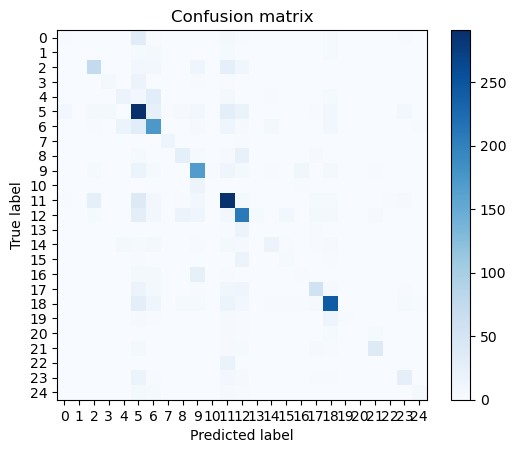

Accuracy:  0.5846262341325811
F1 score 'macro' 0.3686437720199017
ARI 0.3534


In [6]:
dft = df.sample(10000)
tags_to_keep = dft.Single_most_used_tag.value_counts()[:25].index.to_list()

X = dft.loc[df.Single_most_used_tag.isin(tags_to_keep)]
y = LabelEncoder().fit_transform(X.Single_most_used_tag)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=125, stratify=y)


X_train_ = X_train.no_stopword.apply(lambda x: " ".join(x))

vectorizer = CountVectorizer().fit(X_train_)
X_train_vec = vectorizer.transform(X_train_)
X_test_vec = vectorizer.transform(X_test.no_stopword.apply(lambda x: " ".join(x)))


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_vec.toarray())
X_test_sc = scaler.transform(X_test_vec.toarray())
time_0 = time.time()
clf = LogisticRegression(multi_class='ovr').fit(X_train_vec, y_train)
fit_time = time.time()-time_0
time_0 = time.time()
y_pred = clf.predict(X_test_vec)
predict_time=time.time()-time_0
accuracy, jaccard, f1_macro, precision, recall, ari = plot_results(y_test, y_pred)
Results.loc[len(Results)] = ["",
                                     accuracy, jaccard, f1_macro, precision, recall, ari, fit_time,predict_time]

In [11]:
n_components = 3000
pca = PCA(n_components=n_components)
time_1=time.time()
pca.fit(X_train_sc)
print("fit time PCA", time_1-time.time())
pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)



fit time PCA -625.4697139263153


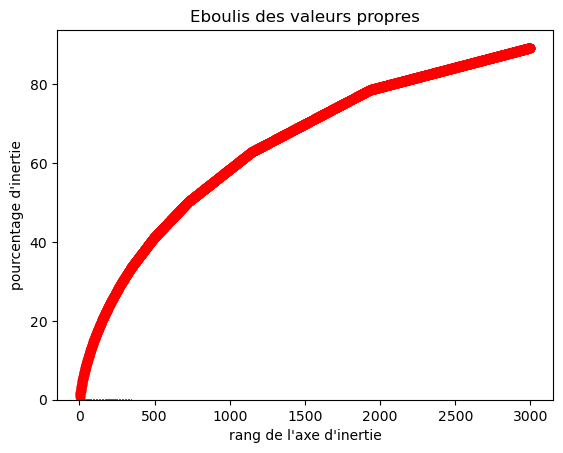

In [12]:
scree_cum = scree.cumsum()
x_list = range(1, n_components+1)

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

the vocabulary for the sampled df comprises 79325 words
PCA allow to reduce this vocabularu to 1000 variables that can explain 100% of variations


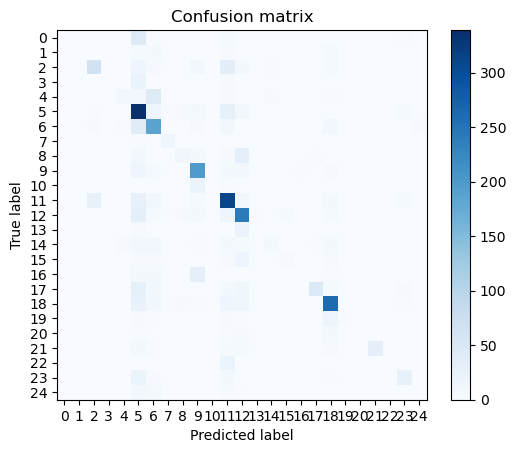

Accuracy:  0.6184767277856136
F1 score 'macro' 0.3367998287686805
ARI 0.4001


In [13]:
print(f"the vocabulary for the sampled df comprises {X_train_sc.shape[1]} words")
print("PCA allow to reduce this vocabularu to 1000 variables that can explain 100% of variations")


time_0 = time.time()
clf = LogisticRegression(multi_class='ovr').fit(pca.transform(X_train_vec.toarray()), y_train)
fit_time=time.time()-time_0
time_0 = time.time()
y_pred = clf.predict(pca.transform(X_test_vec.toarray()))
predict_time=time.time()-time_0

accuracy, jaccard, f1_macro, precision, recall, ari = plot_results(y_test, y_pred)
Results.loc[len(Results)] = ["",
                                     accuracy, jaccard, f1_macro, precision, recall, ari, fit_time,predict_time]

In [15]:
Results

,Model,Jaccard,Accuray,f1_score,Precision,Recall,ARI,fit_time,predict
0,,0.257297,0.584626,0.368644,0.428857,0.352189,0.353366,60.098630,0.018729
1,,0.228458,0.608956,0.318248,0.551385,0.305709,0.383234,51.584566,16.899304
2,,0.242948,0.618477,0.336800,0.526484,0.323935,0.400080,64.743445,24.747833


In [89]:
df = df.loc[df['Tags_200_list'].apply(lambda x: len(x)) >= 3][['Tags_200_list','Single_most_used_tag','no_stopword']]
df.to_csv('Cleaned_SOF_OCP_P5_choose_multinomial.csv', encoding='utf-8', sep='\t', header=True, index=False)